# U5 - Abdullah Barhoum (5041774) - Katharina Müller (5284090)

# Assignment 5: Block Matching and Harris Corner Detection
## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
from skimage.draw import circle
import numpy as np
import cv2

In [2]:
# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg')

In [3]:
def generate_blocks(img, block_size = 10, block_stride = 150):
    H, W, C = img.shape
    half_block_size = block_size // 2
    block_centers = []
    for y in range(0, H, block_stride):
        for x in range(0, W, block_stride):
            block_centers.append((y, x))
    return block_centers   

In [4]:
def get_movement_vectors(img1, img2, blocks, block_size=10, window_size=100, in_window_stride=5):
    H, W, C = img1.shape
    in_image = lambda y, x: H > y >= 0 and W > x >= 0

    half_block_size = block_size // 2
    half_window_size = window_size // 2

    new_blocks = []
    for y, x in blocks:  # top left of block
        original_block = img1[y:y + block_size, x:x + block_size]

        # go through the search window in the second image
        top = y - (half_window_size - half_block_size)
        left = x - (half_window_size - half_block_size)

        min_difference = float('inf')
        most_similar_block = (0, 0)
        
        # w_y is window y, w_x is window x
        for w_y in range(top, top + window_size, in_window_stride):
            for w_x in range(left, left + window_size, in_window_stride):
                end_y = w_y + block_size
                end_x = w_x + block_size
                if not in_image(w_y, w_x) or not in_image(end_y, end_x):
                    continue
                current_block = img2[w_y:end_y , w_x:end_x]
                # difference
                diff = ((original_block - current_block)**2).sum()
                if diff < min_difference:
                    min_difference = diff
                    most_similar_block = (w_y, w_x)
        new_blocks.append(most_similar_block)
    return new_blocks

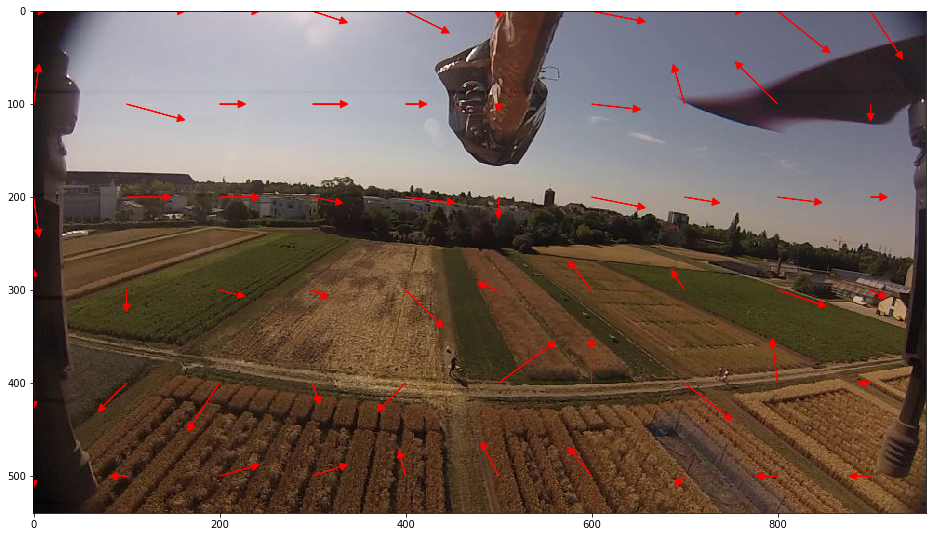

In [5]:
def run():
    block_size = 20
    block_stride = 100
    window_size = 100
    in_window_stride = 5
    
    blocks = generate_blocks(copter1, block_size, block_stride)
    new_blocks = get_movement_vectors(copter1, copter2, blocks, block_size,
                                      window_size, in_window_stride)
    plt.figure(figsize=(16, 16))
    for (y1, x1), (y2, x2) in zip(blocks, new_blocks):
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color='red', head_width=8, head_length=8)
    plt.imshow(copter2)
    plt.show()

run()

## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

Algorithm: See Lecture 5 Slide 38/58 

* calculate gradients using sobel kernel Gx Gy
* calculate Gxx Gyy Gxy
* calculate sum of products of derivatives at each pixel
    * __NOTE__: products of derivatives are Gxx Gyy Gxy
* define at each pixel the matrix Hxy given in the lecture at slide 38/58
* compute ` R = det(Hxy) - k * trace(Hxy)^2`
    * where $k : [0.04, 0.06]$
    * trace = a + d from the matrix `[[ab],[cd]]`
        * or `mat[0][0] + mat[1][1]`
* compare R value to a threshold that defines a "good" corner
    * Threshold was 10,000
* save `x,y` for the best R values
* Dont forget to use `calcOpticalFlowPyrLK` from opencv2
    * you would probably need `reshape(100, 1, 2)` for the prevPoints parameter
* draw vectors from x, y to calculated x, y from calcOpticalFlowPyrLK